In [52]:


patient_details = {
    "health": "good",
    "geo": "9384z5bj",
    "user_id": "25601",
    "nickname": "testuser",
    "title": "testtitle",
    "home_longitude": "0.0",
    "home_latitude": "0.0",
    "birthday": "2020-01-01",
    "sex": "FEMALE",
    "medical_preconditions": "",
}

user_id = patient_details["user_id"]
zeitspanne = "Monat"
timespan = {"Tag": "day", "Woche": "week", "Monat": "month", "Jahr": "year"}[zeitspanne]
change_date = "2021-01-01"

print(user_id)

direction = "über"  # "über" or "unter"
typ = None  # "systolisch", "diastolisch" or None
limit = 80  # integer value or 0



25601


In [53]:
class MockDispatcher:
    def __init__(self):
        pass

    def utter_message(self, message):
        print(message)

    def utter_message(self, image):
        print(image)


dispatcher = MockDispatcher()

In [54]:
if timespan:
    date_filter = (
        f"AND CAST(recorded_at AS timestamp) >= NOW() - INTERVAL '3 {timespan}'"
    )
elif change_date:
    date_filter = f"AND CAST(recorded_at AS timestamp) >= '{change_date}'"
else:
    date_filter = (
        f"AND CAST(recorded_at AS timestamp) >= NOW() - INTERVAL '3 {timespan}'"
    )

In [55]:
query = f"""
                SELECT
                    systolic,
                    diastolic,
                    pulse,
                    recorded_at
                FROM 
                    bloodpressure
                WHERE 
                    user_id = {user_id}
                    {date_filter}
            """

In [56]:
from actions.utils.db_utils import DBHandler

results = DBHandler().execute_query(query)
results

Executing query to database: 
                SELECT
                    systolic,
                    diastolic,
                    pulse,
                    recorded_at
                FROM 
                    bloodpressure
                WHERE 
                    user_id = 25601
                    AND CAST(recorded_at AS timestamp) >= NOW() - INTERVAL '3 month'
            


[(118, 78, 68, '2024-04-28 11:28:00.803334'),
 (135, 66, 65, '2024-03-17 07:06:48.007571'),
 (138, 69, 65, '2024-03-18 07:00:54.052326'),
 (107, 57, 67, '2024-03-19 07:06:51.440792'),
 (92, 53, 65, '2024-03-20 07:07:02.418874'),
 (111, 62, 64, '2024-03-23 07:11:35.092762'),
 (125, 63, 64, '2024-03-24 07:01:46.198838'),
 (144, 73, 61, '2024-03-25 07:02:10.862496'),
 (151, 73, 64, '2024-03-26 07:01:45.393817'),
 (174, 89, 63, '2024-03-27 07:01:00.567159'),
 (117, 61, 61, '2024-03-28 07:30:14.778453'),
 (134, 73, 62, '2024-03-29 07:45:16.170661'),
 (127, 68, 64, '2024-03-30 07:01:10.262859'),
 (140, 72, 62, '2024-04-01 07:01:38.267787'),
 (131, 69, 65, '2024-04-04 07:18:11.807233'),
 (122, 69, 64, '2024-04-05 07:05:23.112214'),
 (114, 57, 58, '2024-04-06 07:58:18.893213'),
 (145, 72, 60, '2024-04-07 07:14:26.712911'),
 (112, 62, 67, '2024-04-08 07:01:06.590836'),
 (142, 75, 66, '2024-04-09 07:01:06.451644'),
 (142, 75, 60, '2024-04-11 07:01:08.029084'),
 (103, 59, 50, '2024-04-16 08:29:05

In [57]:
from datetime import datetime

results = [
    (
        systolic,
        diastolic,
        pulse,
        datetime.strptime(recorded_at, "%Y-%m-%d %H:%M:%S.%f"),
    )
    for systolic, diastolic, pulse, recorded_at in results
]

In [58]:
count_bp_measurements = len(results)

In [59]:
systolic_span = (130, 150)
# TODO systolic_span, diastolic_span = get_blood_pressure_spans(tracker, user_id)
diastolic_span = (80, 95)
if typ == "systolisch" and limit:
    systolic_span = (limit, limit)
elif typ == "diastolisch" and limit:
    diastolic_span = (limit, limit)
#systolic_span, diastolic_span, _ = get_blood_pressure_spans(tracker, patient_details)

In [60]:
def message_bp_measurements(results, typ, span):
    of_range_bp_measurements = [
        (value, recorded_at)
        for value, recorded_at in results
        if (value > span[1] and direction == "über")
           or (value < span[0] and direction == "unter")
    ]
    of_range_quote = round(len(of_range_bp_measurements) / len(results) * 100)
    dispatcher.utter_message(f"Von den {count_bp_measurements} Blutdruckmessungen " +
                             (f"in den letzten 3 {zeitspanne}en" if not change_date else ("seit dem " + change_date)) +
                             " liegen " +
                             str(len(of_range_bp_measurements)) +
                             f" ({of_range_quote}%) der {typ} Blutdruckmessungen " +
                             str(direction) + " " + str(span[1]) +
                             " mmHg."
                             )

    morning_bp_measurements = [
        (value, recorded_at)
        for value, recorded_at in of_range_bp_measurements
        if 6 <= recorded_at.hour < 12
    ]
    evening_bp_measurements = [
        (value, recorded_at)
        for value, recorded_at in of_range_bp_measurements
        if 16 <= recorded_at.hour < 24
    ]
    quote_morning = round(len(morning_bp_measurements) / len(of_range_bp_measurements) * 100)
    quote_evening = round(len(evening_bp_measurements) / len(of_range_bp_measurements) * 100)
    if 60 <= quote_morning < 98:
        dispatcher.utter_message(f"{quote_morning}% dieser Ausreißer wurden am Morgen aufgenommen.")
    elif 60 <= quote_evening < 98:
        dispatcher.utter_message(f"{quote_evening}% dieser Ausreißer wurden am Abend aufgenommen.")
    elif quote_morning >= 95:
        dispatcher.utter_message("Alle diese Ausreißer wurden am Morgen vorgenommen.")
    elif quote_evening >= 95:
        dispatcher.utter_message("Alle diese Ausreißer wurden am Abend vorgenommen.")
    else:
        dispatcher.utter_message("Die Ausreißer sind gleichmäßig über den Tag verteilt.")


if typ == "systolisch" or typ not in ["diastolisch", "systolisch"]:
    message_bp_measurements([(systolic, recorded_at) for systolic, diastolic, pulse, recorded_at in results],
                            "systolisch", systolic_span)
if typ == "diastolisch" or typ not in ["diastolisch", "systolisch"]:
    message_bp_measurements([(diastolic, recorded_at) for systolic, diastolic, pulse, recorded_at in results],
                            "diastolisch", diastolic_span)

Von den 47 Blutdruckmessungen seit dem 2021-01-01 liegen 8 (17%) der systolisch Blutdruckmessungen über 150 mmHg.
Alle diese Ausreißer wurden am Morgen vorgenommen.
Von den 47 Blutdruckmessungen seit dem 2021-01-01 liegen 0 (0%) der diastolisch Blutdruckmessungen über 95 mmHg.


ZeroDivisionError: division by zero

In [ ]:
filtered_interesting_results = [
    (systolic, diastolic, pulse, recorded_at) for systolic, diastolic, pulse, recorded_at in results
    if
    (systolic > systolic_span[1] and direction == "über") or (systolic < systolic_span[0] and direction == "unter") or
    (diastolic > diastolic_span[1] and direction == "über") or (diastolic < diastolic_span[0] and direction == "unter")
]


def get_time_of_day(recorded_at):
    if 6 <= recorded_at.hour < 12:
        return 'Morgen'
    elif 12 <= recorded_at.hour < 16:
        return 'Nachmittag'
    elif 16 <= recorded_at.hour < 22:
        return 'Abend'
    elif 22 <= recorded_at.hour < 24 or 0 <= recorded_at.hour < 6:
        return 'Nacht'


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for demonstration purposes
data = {
    'Systolic': [systolic for systolic, diastolic, pulse, recorded_at in results],
    'Diastolic': [diastolic for systolic, diastolic, pulse, recorded_at in results],
    'Daytime': [get_time_of_day(recorded_at) for systolic, diastolic, pulse, recorded_at in
                results]
}

df = pd.DataFrame(data)

# Create scatter plot using seaborn
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df, x='Systolic', y='Diastolic', hue='Daytime', style='Daytime', palette='deep')
# TODO systolic_span, diastolic_span = get_blood_pressure_spans(tracker, user_id)
systolic_span = (130, 150)
diastolic_span = (80, 95)
plt.title('Blood Pressure Readings Grouped by Daytime - Outliers Only')
plt.xlabel('Systolic (mmHg)')
plt.ylabel('Diastolic (mmHg)')
plt.axvspan(systolic_span[0], systolic_span[1], color='green', alpha=0.1)
print(systolic_span, diastolic_span)
plt.axhspan(diastolic_span[0], diastolic_span[1], color='green', alpha=0.1)
plt.legend(title='Daytime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## details_ausreisser

In [61]:

from actions.utils import utils

pretty_change_date = pd.to_datetime(change_date).strftime('%d.%m.%Y')
since_date = False  # True
# change_date = "2024-03-01"
data = {
    'Datum': [recorded_at for systolic, diastolic, pulse, recorded_at in results],
    'Systolisch': [int(systolic) for systolic, diastolic, pulse, recorded_at in results],
    'Diastolisch': [int(diastolic) for systolic, diastolic, pulse, recorded_at in results],
    'Puls': [int(pulse) for systolic, diastolic, pulse, recorded_at in results],
    'Tageszeit_For_Hue': [utils.get_time_of_day(recorded_at) + " Ausreißer" for systolic, diastolic, pulse, recorded_at
                          in
                          results],
    'Tageszeit': [utils.get_time_of_day(recorded_at) for systolic, diastolic, pulse, recorded_at in results]

}

M
/Users/julianstrietzel/personal/nlpseba/rasa2/tmp_systolisch_boxplot_Monat_and_outliers_2024-06-16 17:29:15.677423.png
/Users/julianstrietzel/personal/nlpseba/rasa2/tmp_diastolisch_boxplot_Monat_and_outliers_2024-06-16 17:29:16.208495.png


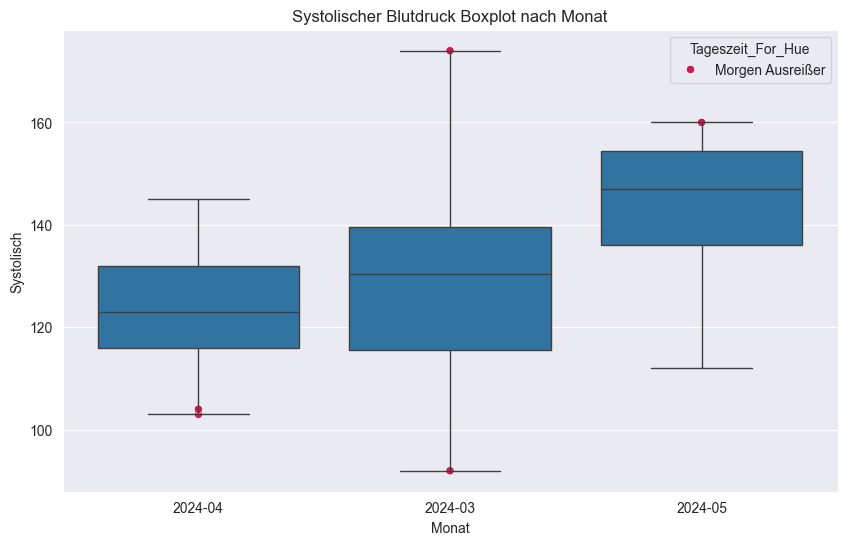

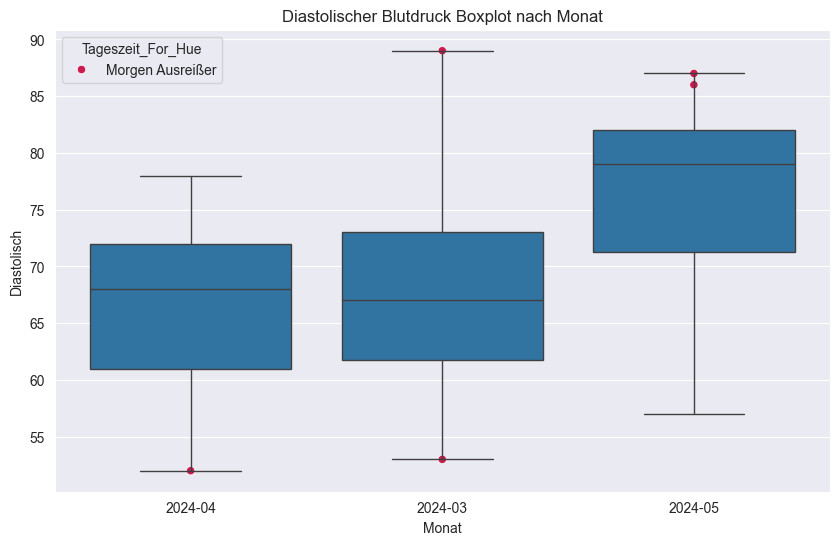

In [68]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns

df = pd.DataFrame(data)


# Function to detect outliers
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 0.5 * iqr
    upper_bound = q3 + 0.5 * iqr
    return (series < lower_bound) | (series > upper_bound)


# Add outlier columns
df['Systolische Ausreißer'] = detect_outliers(df['Systolisch'])
df['Diastolische Ausreißer'] = detect_outliers(df['Diastolisch'])

print(timespan.capitalize()[0])
# Group by month for the boxplot
df[zeitspanne.capitalize()] = df['Datum'].dt.to_period(timespan.capitalize()[0]).astype(str)


def plot_box_and_outliers(typ=typ):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=zeitspanne.capitalize(), y=typ.capitalize(), data=df)
    sns.scatterplot(x=zeitspanne.capitalize(), y=typ.capitalize(), data=df[df[f'{typ.capitalize()}e Ausreißer']],
                    hue='Tageszeit_For_Hue', palette='rocket')
    plt.title(f'{typ.capitalize()}er Blutdruck Boxplot nach {zeitspanne.capitalize()}')

    if since_date:
        df["Änderungsdatum"] = pd.to_datetime(change_date).to_period(timespan.capitalize()[0])
        vline = plt.axvline(x=df["Änderungsdatum"].astype(str).iloc[0], color='red', linestyle='--',
                            label='Änderungsdatum' + f' ({change_date})')
        ax = plt.gca()
        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        vline.set_transform(trans + transforms.ScaledTranslation(-20 / 72., 0, plt.gcf().dpi_scale_trans))

        plt.legend()
        # filename = os.getcwd() + f'tmp_{typ}_boxplot_{zeitspanne}_and_outliers_' + str(datetime.now()) + ".png"
    filename = str(pathlib.Path().parent.absolute() / (f'tmp_{typ}_boxplot_{zeitspanne}_and_outliers_' + str(
        datetime.now()) + ".png"))
    plt.savefig(filename)
    return filename


if typ in ["diastolisch", "systolisch"]:
    dispatcher.utter_message(image=plot_box_and_outliers())
else:
    dispatcher.utter_message(image=plot_box_and_outliers("systolisch"))
    dispatcher.utter_message(image=plot_box_and_outliers("diastolisch"))


In [63]:


from actions.utils.utils import at_the_last_prefix

current_date_one_timespan_ago = (
        pd.to_datetime(datetime.now()) - pd.DateOffset(months=1 if zeitspanne == "Monat" else 1,
                                                       days=1 if zeitspanne == "Tag" else 0,
                                                       weeks=1 if zeitspanne == "Woche" else 0,
                                                       years=1 if zeitspanne == "Jahr" else 0)).strftime(
    "%Y-%m-%d")
df_recently = df[df['Datum'] >= current_date_one_timespan_ago] if not since_date else df[
    df['Datum'] >= pd.to_datetime(change_date)]

# In der letzten Woche waren 50% der systolischen und 30% der diastolischen Messungen extreme Ausreißer.
if len(df_recently) > 0:
    sys_outliers_quote = round(
        len(df_recently[df_recently['Systolische Ausreißer']]) / len(df_recently) * 100)
    dia_outliers_quote = round(len(df_recently[df_recently['Diastolische Ausreißer']]) / len(df_recently) * 100)
    dynamic_message = (
                          at_the_last_prefix[zeitspanne]
                          if not since_date
                          else f"Seit dem {pd.to_datetime(change_date).strftime('%d.%m.%Y')}"
                      ) + (
                          f" gab es keine Ausreißer."
                          if sys_outliers_quote == 0 and dia_outliers_quote == 0
                          else (
                                  " waren " + str(sys_outliers_quote) + "% der systolischen und "
                                  + str(dia_outliers_quote)
                                  + "% der diastolischen Messungen extreme Ausreißer."
                          )
                      )
    dispatcher.utter_message(dynamic_message)
else:
    dispatcher.utter_message(
        "Es gibt keine Messungen " + (
            at_the_last_prefix[zeitspanne].lower() + "."
            if not since_date
            else "seit dem " + pretty_change_date + "."
        )
    )


Im letzten Monat waren 11% der systolischen und 11% der diastolischen Messungen extreme Ausreißer.


In [64]:
import numpy as np

# set half of the sys outliers Tageszeit to Abend
data = {
    'Datum': pd.date_range(start='2024-05-16', periods=9, freq='D').to_series() + pd.to_timedelta(
        np.random.randint(0, 86400, size=9), unit='s'),
    'Systolisch': [136, 156, 145, 154, 152, 147, 122, 160, 147],
    'Diastolisch': [86, 81, 84, 82, 81, 80, 61, 82, 78],
    'Puls': [64, 61, 65, 63, 65, 63, 67, 63, 61],
    'Tageszeit_For_Hue': ['Morgen Ausreißer'] * 9,
    'Tageszeit': ['Morgen', 'Abend', 'Morgen', 'Abend', 'Morgen', 'Abend', 'Morgen', 'Abend', 'Morgen'],
    'Systolische Ausreißer': [
        True, True, False, True, True, True, False, True, True],
    'Diastolische Ausreißer': [True, True, False, True, True, True, False, True, False],
    'Monat': ['2024-05'] * 9
}

df_recently = pd.DataFrame(data)
recent_sys_outliers = df_recently[df_recently['Systolische Ausreißer']]
recent_dia_outliers = df_recently[df_recently['Diastolische Ausreißer']]

if len(df_recently["Tageszeit"].unique()) > 1:
    most_common_tageszeit = (pd.concat([recent_sys_outliers, recent_dia_outliers]))["Tageszeit"].mode()[0]
    count_sys_outliers = len(recent_sys_outliers)
    count_sys_at_tageszeit = len(recent_sys_outliers[recent_sys_outliers["Tageszeit"] == most_common_tageszeit])
    count_dia_outliers = len(recent_dia_outliers)
    count_dia_at_tageszeit = len(recent_dia_outliers[recent_dia_outliers["Tageszeit"] == most_common_tageszeit])
    dispatcher.utter_message(
        f"{round(count_sys_at_tageszeit / count_sys_outliers * 100)}% der systolischen und " +
        f"{round(count_dia_at_tageszeit / count_dia_outliers * 100)}% der diastolischen Ausreißer " +
        "wurden am " + most_common_tageszeit.capitalize() + " aufgenommen.")

else:
    dispatcher.utter_message(
        "Alle Ausreißer wurden am " + df["Tageszeit"].unique()[0].capitalize() + " aufgenommen.")

57% der systolischen und 67% der diastolischen Ausreißer wurden am Abend aufgenommen.


In [65]:
recent_sys_outliers
df_recently["sys_above"] = recent_sys_outliers["Systolisch"] > systolic_span[1]
df_recently["dia_above"] = recent_dia_outliers["Diastolisch"] > diastolic_span[1]
df_recently["sys_below"] = recent_sys_outliers["Systolisch"] < systolic_span[0]
df_recently["dia_below"] = recent_dia_outliers["Diastolisch"] < diastolic_span[0]
perc_above_sys = df_recently["sys_above"].sum() / len(recent_sys_outliers) * 100
perc_above_dia = df_recently["dia_above"].sum() / len(recent_dia_outliers) * 100
perc_below_sys = df_recently["sys_below"].sum() / len(recent_sys_outliers) * 100
perc_below_dia = df_recently["dia_below"].sum() / len(recent_dia_outliers) * 100

if perc_above_sys > 0 or perc_below_sys > 0:
    dispatcher.utter_message(
        f"{round(max(perc_above_sys, perc_below_sys))}% der systolischen Ausreißer liegen {f'über {systolic_span[1]} mmHg' if perc_above_sys > perc_below_sys else f'unter {systolic_span[0]} mmHg'}.")
else:
    dispatcher.utter_message("Keine systolischen Ausreißer liegen außerhalb des Zielkorridors.")

if perc_above_dia > 0 or perc_below_dia > 0:
    dispatcher.utter_message(
        f"{round(max(perc_above_dia, perc_below_dia))}% der diastolischen Ausreißer liegen {f'über {diastolic_span[1]} mmHg' if perc_above_dia > perc_below_dia else f'unter {diastolic_span[0]} mmHg'}.")
else:
    dispatcher.utter_message("Keine diastolischen Ausreißer liegen außerhalb des Zielkorridors.")


57% der systolischen Ausreißer liegen über 150 mmHg.
Keine diastolischen Ausreißer liegen außerhalb des Zielkorridors.


In [66]:
if since_date:
    query = f"""
                SELECT
                    systolic,
                    diastolic,
                    pulse,
                    recorded_at
                FROM 
                    bloodpressure
                WHERE 
                    user_id = {user_id}
                    AND CAST(recorded_at AS timestamp) <= '{change_date}'
            """

In [67]:
data = {
    'Datum': [recorded_at for systolic, diastolic, pulse, recorded_at in results],
    'Systolisch': [int(systolic) for systolic, diastolic, pulse, recorded_at in results],
    'Diastolisch': [int(diastolic) for systolic, diastolic, pulse, recorded_at in results],
    'Puls': [int(pulse) for systolic, diastolic, pulse, recorded_at in results],
    'Tageszeit_For_Hue': [utils.get_time_of_day(recorded_at) + " Ausreißer" for systolic, diastolic, pulse, recorded_at
                          in
                          results],
    'Tageszeit': [utils.get_time_of_day(recorded_at) for systolic, diastolic, pulse, recorded_at in results]

}

df_before = pd.DataFrame(data)
sys_percent_after = len(recent_sys_outliers) / len(df_recently) * 100
dia_percent_after = len(recent_dia_outliers) / len(df_recently) * 100

# Add outlier columns
df_before['Systolische Ausreißer'] = detect_outliers(df_before['Systolisch'])
df_before['Diastolische Ausreißer'] = detect_outliers(df_before['Diastolisch'])

sys_percent_before = len(df_before[df_before['Systolische Ausreißer']]) / len(df_before) * 100
dia_percent_before = len(df_before[df_before['Diastolische Ausreißer']]) / len(df_before) * 100

dispatcher.utter_message(
    f"Die Quote der Ausreißer im systolischen Blutwert hat sich seit dem {pretty_change_date} von {round(sys_percent_before)}% auf {round(sys_percent_after)}% " +
    ("erhöht." if sys_percent_after > sys_percent_before else "verringert.")
)
dispatcher.utter_message(
    f"Die Quote der Ausreißer im diastolischen Blutwert hat sich seit dem {pretty_change_date} von {round(dia_percent_before)}% auf {round(dia_percent_after)}% " +
    ("erhöht." if dia_percent_after > dia_percent_before else "verringert.")
)




Die Quote der Ausreißer im systolischen Blutwert hat sich seit dem 01.01.2021 von 11% auf 78% erhöht.
Die Quote der Ausreißer im diastolischen Blutwert hat sich seit dem 01.01.2021 von 11% auf 67% erhöht.
